In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

C:\Users\antho\Anaconda3\lib\site-packages\backtesting\_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [4]:
import scipy.interpolate as interp
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [5]:
sp_df = yf.download('^GSPC', 
                      start='2011-09-13', 
                      end='2019-12-13', 
                      progress=False,interval='1d')
ohlc = sp_df.iloc[:,:4]
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010
...,...,...,...,...
2019-12-06,3134.620117,3150.600098,3134.620117,3145.909912
2019-12-09,3141.860107,3148.870117,3135.459961,3135.959961
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020


In [6]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

# Strategies

In [7]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [8]:
class SmaCross(Strategy):
    
    n1 = 50
    n2 = 200
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [9]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [10]:
class EmaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [11]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [12]:
class DemaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

# Strategies for Time Horizons

In [21]:
def time_horiz(hist,ma):
    
    if ma == 'SMA':
        bt = Backtest(hist,SmaCross,cash=10000)
    elif ma == 'EMA':
        bt = Backtest(hist,EmaCross,cash=10000)
    elif ma == 'DEMA':
        bt = Backtest(hist,DemaCross,cash=10000)
    
    data, heat = bt.optimize('Sharpe Ratio',n1=range(1,50,2),n2=range(1,50,2),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

    heat.sort_values()
    hmap = heat.groupby(['n1','n2']).mean().unstack()
    hmap

    heat_pic = sns.heatmap(hmap, cmap='Spectral')
    
    tr = hmap.stack()

    n1 = [i[0] for i in tr.index]
    n2 = [i[1] for i in tr.index]

    val = []
    for (i,j) in zip(n1,n2):
        if i<j:
            val.append(tr.loc[i,j])

    px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),100),np.linspace(np.min(n2),np.max(n2),100))
    pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(px,py,pz,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    return data

# 1 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


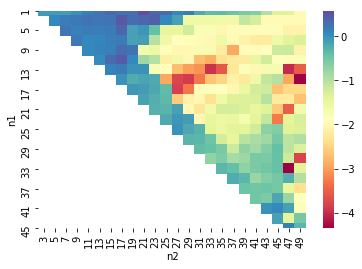

C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


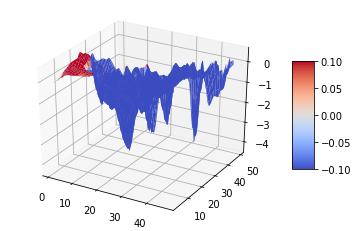

Start                      2018-12-12 00:00:00
End                        2019-12-12 00:00:00
Duration                     365 days 00:00:00
Exposure [%]                           74.5205
Equity Final [$]                       11509.1
Equity Peak [$]                        11571.4
Return [%]                             15.0914
Buy & Hold Return [%]                  19.5204
Max. Drawdown [%]                     -4.10948
Avg. Drawdown [%]                     -1.44494
Max. Drawdown Duration        49 days 00:00:00
Avg. Drawdown Duration        12 days 00:00:00
# Trades                                    11
Win Rate [%]                           72.7273
Best Trade [%]                         4.64204
Worst Trade [%]                       -2.08019
Avg. Trade [%]                         1.15575
Max. Trade Duration           55 days 00:00:00
Avg. Trade Duration           25 days 00:00:00
Expectancy [%]                         1.67201
SQN                                    1.90377
Sharpe Ratio 

In [22]:
time_horiz(yr1,'SMA')

# 1 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


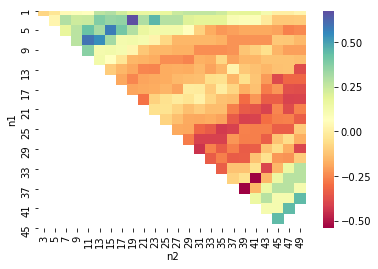

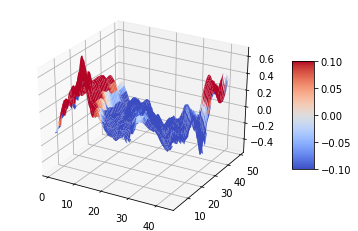

Start                      2018-12-12 00:00:00
End                        2019-12-12 00:00:00
Duration                     365 days 00:00:00
Exposure [%]                           76.1644
Equity Final [$]                         12175
Equity Peak [$]                          12175
Return [%]                             21.7504
Buy & Hold Return [%]                  19.5204
Max. Drawdown [%]                     -4.88741
Avg. Drawdown [%]                     -1.31528
Max. Drawdown Duration        63 days 00:00:00
Avg. Drawdown Duration        13 days 00:00:00
# Trades                                     8
Win Rate [%]                                75
Best Trade [%]                         6.48405
Worst Trade [%]                       -1.46501
Avg. Trade [%]                          1.6676
Max. Trade Duration           61 days 00:00:00
Avg. Trade Duration           35 days 00:00:00
Expectancy [%]                         2.08785
SQN                                     1.9738
Sharpe Ratio 

In [23]:
time_horiz(yr1,'EMA')

# 1 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


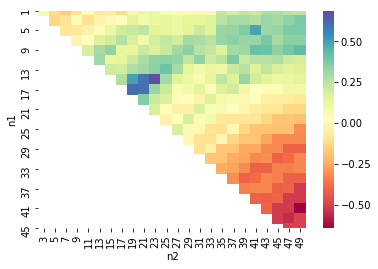

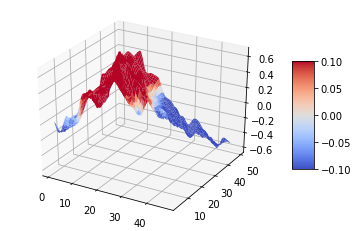

Start                        2018-12-12 00:00:00
End                          2019-12-12 00:00:00
Duration                       365 days 00:00:00
Exposure [%]                              90.137
Equity Final [$]                         11761.8
Equity Peak [$]                          12207.8
Return [%]                               17.6183
Buy & Hold Return [%]                    19.5204
Max. Drawdown [%]                       -5.88911
Avg. Drawdown [%]                       -1.84022
Max. Drawdown Duration          66 days 00:00:00
Avg. Drawdown Duration          17 days 00:00:00
# Trades                                       9
Win Rate [%]                             77.7778
Best Trade [%]                           8.13436
Worst Trade [%]                         -2.98032
Avg. Trade [%]                           2.10524
Max. Trade Duration             56 days 00:00:00
Avg. Trade Duration             37 days 00:00:00
Expectancy [%]                           2.89292
SQN                 

In [24]:
time_horiz(yr1,'DEMA')

# 2 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


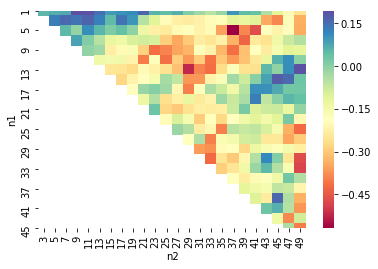

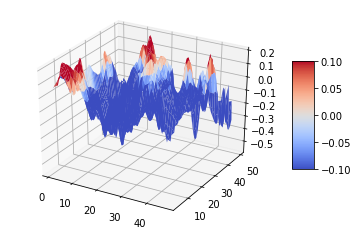

Start                     2017-12-12 00:00:00
End                       2019-12-12 00:00:00
Duration                    730 days 00:00:00
Exposure [%]                          96.7123
Equity Final [$]                      13209.9
Equity Peak [$]                       14135.7
Return [%]                             32.099
Buy & Hold Return [%]                 18.9354
Max. Drawdown [%]                    -10.6044
Avg. Drawdown [%]                    -2.88401
Max. Drawdown Duration      191 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                   73
Win Rate [%]                          49.3151
Best Trade [%]                        6.33531
Worst Trade [%]                      -2.55941
Avg. Trade [%]                       0.386091
Max. Trade Duration          42 days 00:00:00
Avg. Trade Duration          10 days 00:00:00
Expectancy [%]                        1.41417
SQN                                   1.50418
Sharpe Ratio                      

In [25]:
time_horiz(yr2,'SMA')

# 2 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


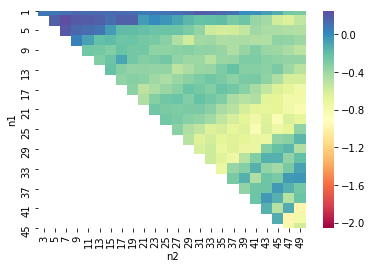

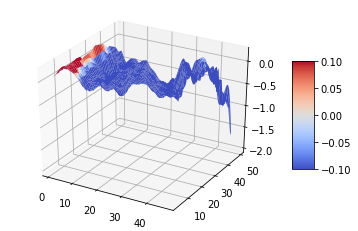

Start                     2017-12-12 00:00:00
End                       2019-12-12 00:00:00
Duration                    730 days 00:00:00
Exposure [%]                          98.7671
Equity Final [$]                      13832.5
Equity Peak [$]                       14111.9
Return [%]                            38.3255
Buy & Hold Return [%]                 18.9354
Max. Drawdown [%]                    -9.60462
Avg. Drawdown [%]                    -2.03693
Max. Drawdown Duration      258 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                   52
Win Rate [%]                          46.1538
Best Trade [%]                        9.05678
Worst Trade [%]                      -2.53567
Avg. Trade [%]                       0.629741
Max. Trade Duration          59 days 00:00:00
Avg. Trade Duration          14 days 00:00:00
Expectancy [%]                        1.76341
SQN                                   1.80401
Sharpe Ratio                      

In [26]:
time_horiz(yr2,'EMA')

# 2 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


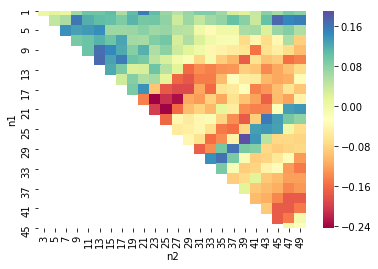

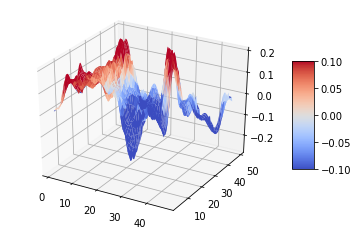

Start                        2017-12-12 00:00:00
End                          2019-12-12 00:00:00
Duration                       730 days 00:00:00
Exposure [%]                             92.0548
Equity Final [$]                           11822
Equity Peak [$]                          13800.2
Return [%]                                 18.22
Buy & Hold Return [%]                    18.9354
Max. Drawdown [%]                         -19.03
Avg. Drawdown [%]                       -2.51811
Max. Drawdown Duration         252 days 00:00:00
Avg. Drawdown Duration          27 days 00:00:00
# Trades                                      12
Win Rate [%]                             41.6667
Best Trade [%]                           11.6527
Worst Trade [%]                         -4.11023
Avg. Trade [%]                           1.06389
Max. Trade Duration            113 days 00:00:00
Avg. Trade Duration             56 days 00:00:00
Expectancy [%]                           4.08155
SQN                 

In [27]:
time_horiz(yr2,'DEMA')

# 4 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


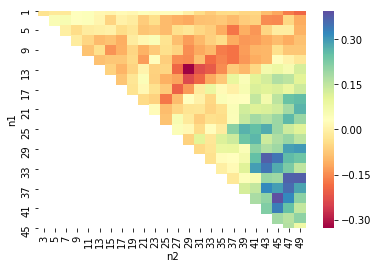

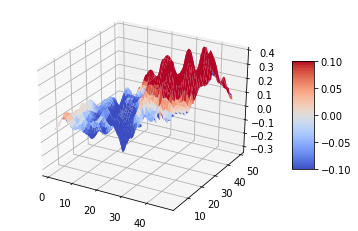

Start                       2015-12-14 00:00:00
End                         2019-12-12 00:00:00
Duration                     1459 days 00:00:00
Exposure [%]                            91.8437
Equity Final [$]                        14375.9
Equity Peak [$]                         16635.9
Return [%]                              43.7591
Buy & Hold Return [%]                   56.7094
Max. Drawdown [%]                      -21.6291
Avg. Drawdown [%]                      -1.58702
Max. Drawdown Duration        353 days 00:00:00
Avg. Drawdown Duration         22 days 00:00:00
# Trades                                     26
Win Rate [%]                            57.6923
Best Trade [%]                          9.85278
Worst Trade [%]                        -6.09282
Avg. Trade [%]                          1.37795
Max. Trade Duration           159 days 00:00:00
Avg. Trade Duration            52 days 00:00:00
Expectancy [%]                          2.51047
SQN                                     

In [28]:
time_horiz(yr4,'SMA')

# 4 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


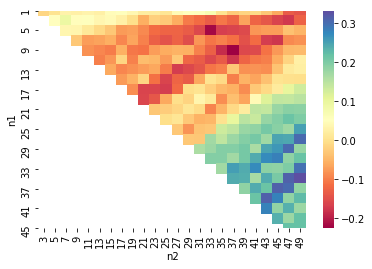

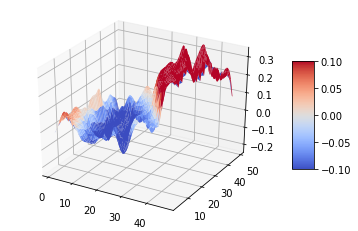

Start                       2015-12-14 00:00:00
End                         2019-12-12 00:00:00
Duration                     1459 days 00:00:00
Exposure [%]                            91.4325
Equity Final [$]                        13032.8
Equity Peak [$]                         13458.5
Return [%]                              30.3282
Buy & Hold Return [%]                   56.7094
Max. Drawdown [%]                      -13.6785
Avg. Drawdown [%]                      -1.47284
Max. Drawdown Duration        364 days 00:00:00
Avg. Drawdown Duration         35 days 00:00:00
# Trades                                      9
Win Rate [%]                            55.5556
Best Trade [%]                          19.4532
Worst Trade [%]                         -4.6226
Avg. Trade [%]                          2.52769
Max. Trade Duration           495 days 00:00:00
Avg. Trade Duration           149 days 00:00:00
Expectancy [%]                          5.51663
SQN                                    0

In [29]:
time_horiz(yr4,'EMA')

# 4 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


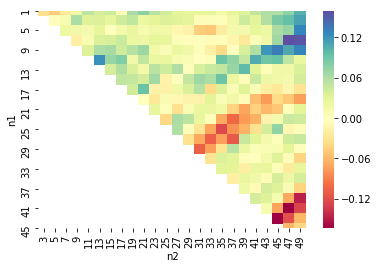

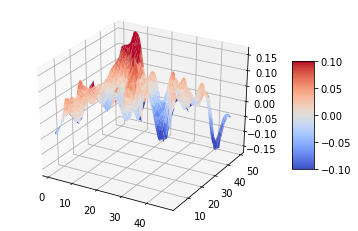

Start                       2015-12-14 00:00:00
End                         2019-12-12 00:00:00
Duration                     1459 days 00:00:00
Exposure [%]                             98.218
Equity Final [$]                        12743.1
Equity Peak [$]                         13000.4
Return [%]                              27.4307
Buy & Hold Return [%]                   56.7094
Max. Drawdown [%]                      -16.5964
Avg. Drawdown [%]                      -2.92674
Max. Drawdown Duration        454 days 00:00:00
Avg. Drawdown Duration         53 days 00:00:00
# Trades                                     57
Win Rate [%]                             45.614
Best Trade [%]                          14.0265
Worst Trade [%]                        -3.87295
Avg. Trade [%]                         0.448975
Max. Trade Duration           115 days 00:00:00
Avg. Trade Duration            26 days 00:00:00
Expectancy [%]                           1.8323
SQN                                     

In [30]:
time_horiz(yr4,'DEMA')